In [1]:
import importlib
from pathlib import Path
import itertools
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import scipy.stats
from statsmodels import api as sm
import pyBigWig
import logomaker
import json

from Modules import utils, plot_utils

In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def mywho():
    np.who({k: v for k, v in globals().items() if k[0]!= '_'})

In [3]:
species = 'SCerevisiae'

Load one_hot genomes

In [4]:
with np.load(Path(data_dir, species, 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'genome', 'S288c_Mpneumo.npz')) as f:
    one_hots_pneu = {k: f[k] for k in f.keys() if k != 'Mito'}

Load labels

In [5]:
with np.load(Path(data_dir, species, 'data', 'labels_myco_nuc.npz')) as f:
    myco_nuc = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'labels_pneu_nuc.npz')) as f:
    pneu_nuc = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_ratio.npz')) as f:
    myco_coh_ratio = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_ratio.npz')) as f:
    pneu_coh_ratio = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_ratio.npz')) as f:
    myco_pol_ratio = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_ratio.npz')) as f:
    pneu_pol_ratio = {k: f[k] for k in f.keys()}

# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh.npz')) as f:
#     myco_coh = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol.npz')) as f:
#     myco_pol = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh.npz')) as f:
#     pneu_coh = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol.npz')) as f:
#     pneu_pol = {k: f[k] for k in f.keys()}

# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_KL.npz')) as f:
#     myco_coh_KL = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_KL.npz')) as f:
#     myco_pol_KL = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_KL.npz')) as f:
#     pneu_coh_KL = {k: f[k] for k in f.keys()}
# with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_KL.npz')) as f:
#     pneu_pol_KL = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_log.npz')) as f:
    myco_coh_log = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_log.npz')) as f:
    myco_pol_log = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_log.npz')) as f:
    pneu_coh_log = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_log.npz')) as f:
    pneu_pol_log = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_log_smooth10.npz')) as f:
    myco_coh_log_smooth10 = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_log_smooth10.npz')) as f:
    myco_pol_log_smooth10 = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_log_smooth10.npz')) as f:
    pneu_coh_log_smooth10 = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_log_smooth10.npz')) as f:
    pneu_pol_log_smooth10 = {k: f[k] for k in f.keys()}

lens = {'myco': {k: len(v) for k, v in myco_nuc.items()},
        'pneu': {k: len(v) for k, v in pneu_nuc.items()}}

In [110]:
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'invalid_myco_coh_log.npz')) as f:
    invalid = {k: f[k] for k in f.keys()}
np.who(invalid)

Name            Shape            Bytes            Type

chrI            13581            108648           int64
chrII           16014            128112           int64
chrIII          30880            247040           int64
chrIV           79064            632512           int64
chrV            26896            215168           int64
chrVI           8955             71640            int64
chrVII          32484            259872           int64
chrVIII         37300            298400           int64
chrIX           15310            122480           int64
chrX            25261            202088           int64
chrXI           6505             52040            int64
chrXII          95544            764352           int64
chrXIII         30001            240008           int64
chrXIV          17689            141512           int64
chrXV           26067            208536           int64
chrXVI          23754            190032           int64
Mmmyco          85613            684904         

In [26]:
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_ratio.bw'), myco_coh_ratio)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_ratio.bw'), myco_pol_ratio)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_ratio.bw'), pneu_coh_ratio)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_ratio.bw'), pneu_pol_ratio)

# utils.write_bw(Path(data_dir, species, 'data', 'labels_myco_nuc.bw'), myco_nuc)
# utils.write_bw(Path(data_dir, species, 'data', 'labels_pneu_nuc.bw'), pneu_nuc)

Raw signals

In [51]:
# Outdated MNase
myco_nuc1 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703666_MNase_Mmyco_rep1.130-200.CPM.bw', 'W303')
pneu_nuc1 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703668_MNase_Mpneumo_rep1.130-200.CPM.bw', 'S288c')
myco_nuc2 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703667_MNase_Mmyco_rep2.130-200.CPM.bw', 'W303')
pneu_nuc2 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703669_MNase_Mpneumo_rep2.130-200.CPM.bw', 'S288c')

In [24]:
myco_coh_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703630_Scc1_Mmyco_rep1.CPM.bw'), 'W303')
myco_coh_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'), 'W303')
pneu_coh_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703640_Scc1_Mpneumo_rep1.CPM.bw'), 'S288c')
pneu_coh_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703641_Scc1-inp_Mpneumo_rep1.CPM.bw'), 'S288c')

myco_pol_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703624_PolII_Mmyco_rep1.CPM.bw'), 'W303')
myco_pol_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703625_PolII-inp_Mmyco_rep1.CPM.bw'), 'W303')
myco_pol_ip2 = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703626_PolII_Mmyco_rep2.CPM.bw'), 'W303')
myco_pol_ctrl2 = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703627_PolII-inp_Mmyco_rep2.CPM.bw'), 'W303')
pneu_pol_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703638_PolII_Mpneumo_rep1.CPM.bw'), 'S288c')
pneu_pol_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703639_PolII-inp_Mpneumo_rep1.CPM.bw'), 'S288c')

In [53]:
for signals in [myco_coh_ip, myco_coh_ctrl, pneu_coh_ip, pneu_coh_ctrl,
                myco_pol_ip, myco_pol_ctrl, myco_pol_ip2, myco_pol_ctrl2, pneu_pol_ip, pneu_pol_ctrl]:
    print(np.sum(np.concatenate(list(signals.values()))))

313678300.0
277992130.0
338243400.0
278769860.0
269219300.0
254790460.0
273671870.0
266927330.0
219618610.0
165207140.0


Signals from Jacques

In [82]:
mnase_myco = utils.load_bw(Path(data_dir, species, 'data', 'mnase_myco.bw'))
mnase_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'mnase_pneumo.bw'))
scc1_myco = utils.load_bw(Path(data_dir, species, 'data', 'scc1_myco.bw'))
scc1_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'scc1_pneumo.bw'))
pol2_myco = utils.load_bw(Path(data_dir, species, 'data', 'pol2_myco.bw'))
pol2_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'pol2_pneumo.bw'))

In [8]:
def remove_artifacts(signals, strand):
    """Exclude regions with abnormally high control signal.

    Regions are excluded by being set to 0.
    There is a slight variation between strands.
    """
    if strand == 'W303':
        signals['chrXII'][482_664:499_263] = 0
    elif strand == 'S288c':
        signals['VIII'][213_000:215_500] = 0
        signals['XII'][458_944:461_406] = 0
    else:
        raise ValueError("strand must be either W303 or S288c")
    return signals

def clipnorm(signals, q=0.99):
    """Clip max signal to a given quantile and normalize between 0 and 1."""
    full = np.concatenate(list(signals.values()))
    quant = np.quantile(full, q)
    return {k: np.clip(v, 0, quant) / quant for k, v in signals.items()}

scc1_myco_finite = {k: np.where(np.abs(v) > 1e38, 0, v) for k, v in scc1_myco.items()}
scc1_pneumo_finite = {k: np.where(np.abs(v) > 1e38, 0, v) for k, v in scc1_pneumo.items() if k!='Mito'}
pol2_myco_finite = {k: np.where(np.abs(v) > 1e38, 0, v) for k, v in pol2_myco.items()}
pol2_pneumo_finite = {k: np.where(np.abs(v) > 1e38, 0, v) for k, v in pol2_pneumo.items() if k!='Mito'}

scc1_myco_clip = clipnorm(remove_artifacts(scc1_myco_finite, 'W303'))
scc1_pneumo_clip = clipnorm(remove_artifacts(scc1_pneumo_finite, 'S288c'))
pol2_myco_clip = clipnorm(remove_artifacts(pol2_myco_finite, 'W303'))
pol2_pneumo_clip = clipnorm(remove_artifacts(pol2_pneumo_finite, 'S288c'))

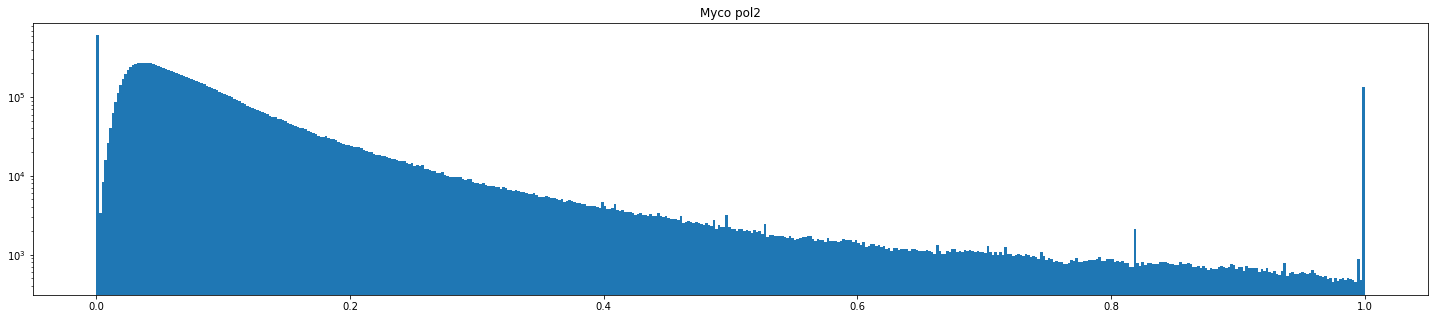

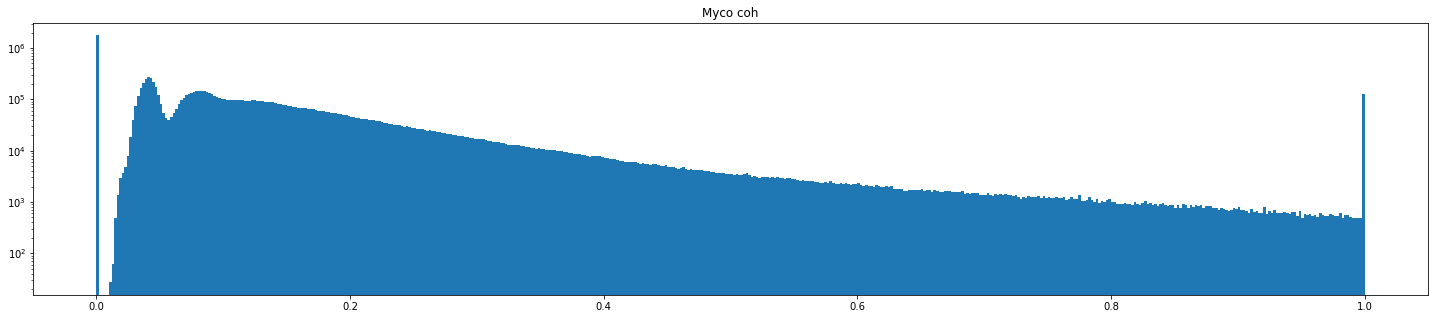

In [114]:
mergem = np.concatenate(list(myco_pol_ratio.values()))
# mergemonm = np.concatenate()
plt.figure(figsize=(25, 5))
plt.title('Myco pol2')
plt.hist(mergem, bins=500, range=(0, 1))
plt.yscale('log')
plt.show()

mergep = np.concatenate(list(pneu_pol_ratio.values()))
plt.figure(figsize=(25, 5))
plt.title('Myco coh')
plt.hist(mergep, bins=500, range=(0, 1))
plt.yscale('log')
plt.show()

In [115]:
sum(lens['pneu'].values())

12889272

In [88]:
uniq, counts = np.unique(mergep, return_counts=True)
len(uniq)

2651521

In [115]:
for key, value in myco_pol_log.items():
    print(key, pearsonr(value, pol2_myco_clip[key])[0])

chrI 0.9852009319007785
chrII 0.9930942476881499
chrIII 0.9707406229117373
chrIV 0.993029805223303
chrV 0.9919763767165062
chrVI 0.9953549400918623
chrVII 0.9891867901691589
chrVIII 0.9850510351424057
chrIX 0.9945766840027968
chrX 0.988015734225473
chrXI 0.9919268257850911
chrXII 0.9901613640704763
chrXIII 0.9829553115279138
chrXIV 0.988668681946394
chrXV 0.9888113568969799
chrXVI 0.9922734282022893
Mmmyco 0.7699189583993414


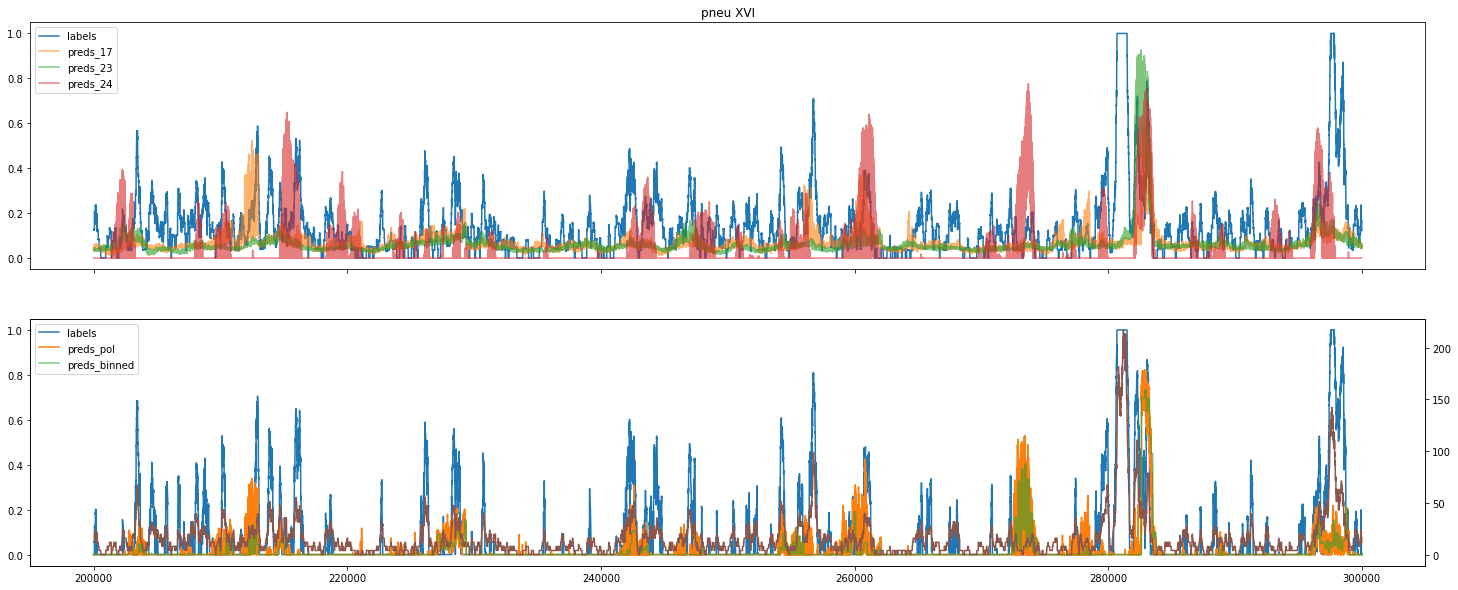

In [43]:
strand = 'pneu' # 'myco' #
chr_id = 'XVI'
start = 200_000
stop = start + 100_000

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(25, 10), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])
ax = axes[0]
ax.set_title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), pneu_coh_KL[chr_id][start:stop], label='pneu_coh')
# ax.plot(np.arange(start, stop), pneu_coh[chr_id][start:stop], label='pneu_coh')
# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')

# ax.plot(np.arange(start, stop), myco_nuc[chr_id][start:stop], label='myco_nuc')
# ax.plot(np.arange(start, stop), preds_monm[chr_id][start:stop], label='preds_myco', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponm[chr_id][start:stop], label='preds_pneu', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_monm2[chr_id][start:stop], label='preds_myco2', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponm2[chr_id][start:stop], label='preds_pneu2', alpha=0.6)

# ax.plot(np.arange(start, stop), pneu_nuc[chr_id][start:stop], label='pneu_nuc')
# ax.plot(np.arange(start, stop), preds_monp[chr_id][start:stop], label='preds_myco')
# ax.plot(np.arange(start, stop), preds_ponp[chr_id][start:stop], label='preds_pneu')

# ax.plot(np.arange(start, stop), pol2_myco_clip[chr_id][start:stop], label='pol2_myco_clip')
ax.plot(np.arange(start, stop), pneu_pol_ratio[chr_id][start:stop], label='labels')
ax.plot(np.arange(start, stop), preds_monp17[chr_id][start:stop], label='preds_17', alpha=0.6)
ax.plot(np.arange(start, stop), preds_monp23[chr_id][start:stop], label='preds_23', alpha=0.6)
ax.plot(np.arange(start, stop), preds_monp24[chr_id][start:stop], label='preds_24', alpha=0.6)
# ax.plot(np.arange(start, stop), np.repeat(preds_monm24[chr_id][::128], 128)[:len(preds_monm24[chr_id])][start:stop], label='preds_binned', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponp15[chr_id][start:stop], label='preds_15', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponp16[chr_id][start:stop], label='preds_16', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponp17[chr_id][start:stop], label='preds_m17', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponp18[chr_id][start:stop], label='preds_18', alpha=0.6)
# ax.plot(np.arange(start, stop), preds_ponp19[chr_id][start:stop], label='preds_19', alpha=0.6)

axes[1].plot(np.arange(start, stop), pneu_pol_log[chr_id][start:stop], label='labels')
axes[1].plot(np.arange(start, stop), preds_monp10[chr_id][start:stop], label='preds_pol')
axes[1].plot(np.arange(start, stop), np.repeat(preds_monp10[chr_id][::128], 128)[:len(preds_monp10[chr_id])][start:stop], label='preds_binned', alpha=0.6)

# ax.plot(np.arange(start, stop), pneu_pol_log[chr_id][start:stop], label='pneu_pol_log')
# ax.plot(np.arange(start, stop), preds_monp[chr_id][start:stop], label='preds_pneu')

# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL', color='k')
# ax2 = ax.twinx()
# ax2.plot(np.arange(start, stop), pol2_myco_finite[chr_id][start:stop], label='pol2_myco', color='k')
ax3 = axes[1].twinx()
ax3.plot(np.arange(start, stop), pneu_pol_ip[chr_id][start:stop], label='pol_ip', color=colors[5])
# ax3.plot(np.arange(start, stop), myco_pol_ip2[chr_id][start:stop], label='myco_pol_ip2', color=colors[2])
# ax3.plot(np.arange(start, stop), myco_pol_ctrl[chr_id][start:stop], label='myco_pol_ctrl', color=colors[6])
# ax3.plot(np.arange(start, stop), myco_pol_ctrl2[chr_id][start:stop], label='myco_pol_ctrl2', color=colors[4])
# ax3.plot(np.arange(start, stop), pneu_coh_ctrl[chr_id][start:stop], label='pneu_coh_ctrl', color=colors[3])
# ax3.set_ylim((-1, 50))
ax.legend()
axes[1].legend()
# ax3.legend()

In [38]:
np.where(preds_monm24[chr_id] > 0.8)

(array([1218556, 1218572, 1218577, 1218580, 1218584, 1218585, 1218588,
        1218592, 1218593, 1218596, 1218612, 1218617, 1218620, 1218624,
        1218625, 1218633, 1218641, 1218644, 1218648, 1218649, 1218656,
        1218657, 1218660, 1218681, 1218689, 1218705, 1218708, 1218713,
        1218721, 1218729, 1218737, 1218753, 1218761, 1218769, 1218777,
        1218785, 1218801, 1218809, 1218817, 1218825, 1218833, 1218849,
        1218857, 1218865, 1218881]),)

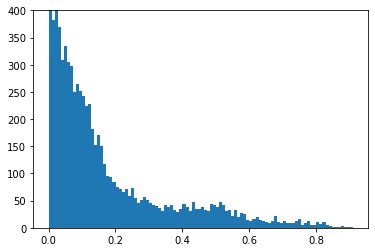

In [37]:
plt.hist(preds_monm24[chr_id], bins=100)
plt.ylim((0, 400))
plt.show()

In [94]:
chr_id = 'Mpneumo'
np.corrcoef([pneu_pol_ratio[chr_id], preds_monp[chr_id], np.repeat(preds_monp[chr_id][::128], 128)[:len(preds_monp[chr_id])]])[0, 1:]

array([0.33441293, 0.34359368])

<AxesSubplot:>

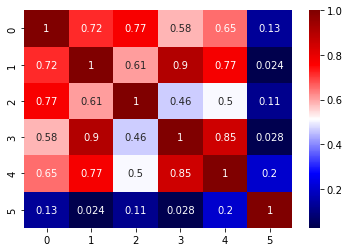

In [161]:
corrs = np.corrcoef([signals['Mmmyco'] for signals in [myco_pol_log, myco_pol_KL, pol2_myco_clip, myco_pol_ip, myco_pol_ip2, preds_m]])
sns.heatmap(corrs, cmap='seismic', annot=True)

In [17]:
def save_corrs_df(model_name, annot, preprocessing):
    if annot == 'coh':
        if preprocessing == '':
            labels_myco, labels_pneu = myco_coh, pneu_coh
        elif preprocessing == '_KL':
            labels_myco, labels_pneu = myco_coh_KL, pneu_coh_KL
        elif preprocessing == '_log':
            labels_myco, labels_pneu = myco_coh_log, pneu_coh_log
        elif preprocessing == '_log_smooth10':
            labels_myco, labels_pneu = myco_coh_log_smooth10, pneu_coh_log_smooth10
        elif preprocessing == '_ratio':
            labels_myco, labels_pneu = myco_coh_ratio, pneu_coh_ratio
    elif annot == 'pol':
        if preprocessing == '':
            labels_myco, labels_pneu = myco_pol, pneu_pol
        elif preprocessing == '_KL':
            labels_myco, labels_pneu = myco_pol_KL, pneu_pol_KL
        elif preprocessing == '_log':
            labels_myco, labels_pneu = myco_pol_log, pneu_pol_log
        elif preprocessing == '_log_smooth10':
            labels_myco, labels_pneu = myco_pol_log_smooth10, pneu_pol_log_smooth10
        elif preprocessing == '_ratio':
            labels_myco, labels_pneu = myco_pol_ratio, pneu_pol_ratio
    elif annot == 'nuc':
        labels_myco, labels_pneu = myco_nuc, pneu_nuc
    df_corrs = pd.DataFrame(index=list(one_hots_myco.keys()) + ['Mpneumo'],
                            columns=['W303_Mmmyco', 'W303_Mmmyco_rev', 'S288c_Mpneumo', 'S288c_Mpneumo_rev'])
    with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
        with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
            for chr_id, labels in labels_myco.items():
                df_corrs.loc[chr_id, 'W303_Mmmyco'] = pearsonr(fm[chr_id], labels)[0]
                df_corrs.loc[chr_id, 'W303_Mmmyco_rev'] = pearsonr(fm[f'{chr_id}_rev'], labels)[0]
                if chr_id != 'Mmmyco':
                    df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id[3:]], labels_pneu[chr_id[3:]])[0]
                    df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id[3:]}_rev'], labels_pneu[chr_id[3:]])[0]
            chr_id = 'Mpneumo'
            df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id], labels_pneu[chr_id])[0]
            df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id}_rev'], labels_pneu[chr_id])[0]
    df_corrs.to_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs{preprocessing}'))
    return df_corrs

model_name = 'model_myco_pol_24'
annot = 'pol' # 'coh' # 'nuc' #
preprocessing = '_ratio' # '_log_smooth10' # '_log' # '' # '_KL' #
for preprocess in ['_ratio']: # ['']: # ['_KL', '', '_log']: #
    if preprocess == preprocessing:
        df_corrs = save_corrs_df(model_name, annot, preprocess)
    else:
        save_corrs_df(model_name, annot, preprocess)
df_corrs

,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.741405,0.71996,0.525871,0.511297
chrII,0.792723,0.796866,0.637958,0.639735
chrIII,0.698607,0.700591,0.517008,0.533077
chrIV,0.765688,0.75623,0.56924,0.560217
chrV,0.800661,0.782292,0.575967,0.564316
chrVI,0.631972,0.692522,0.496852,0.562381
chrVII,0.781652,0.776384,0.594745,0.59755
chrVIII,0.752746,0.751783,0.583362,0.588328
chrIX,0.793954,0.794455,0.541778,0.53162
chrX,0.736266,0.740355,0.566205,0.539614


In [19]:
model_name = 'model_myco_pol_10'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_monm10 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_monp10 = {k: fp[k] for k in fp.keys()}
model_name = 'model_myco_pol_17'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_monm17 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_monp17 = {k: fp[k] for k in fp.keys()}
model_name = 'model_myco_pol_23'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_monm23 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_monp23 = {k: fp[k] for k in fp.keys()}
model_name = 'model_myco_pol_24'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_monm24 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_monp24 = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_14'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_15'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm15 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp15 = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_16'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm16 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp16 = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_17'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm17 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp17 = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_18'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm18 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp18 = {k: fp[k] for k in fp.keys()}
model_name = 'model_pneu_pol_19'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_ponm19 = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_ponp19 = {k: fp[k] for k in fp.keys()}

In [46]:
for model_name in ['model_myco_pol_17', 'model_pneu_pol_17']:
    with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
        preds_myco = {k: fm[k] for k in fm.keys()}
    with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
        preds_pneu = {k: fp[k] for k in fp.keys()}
    utils.write_bw(Path(data_dir, 'SCerevisiae', 'results', model_name, f'preds_{model_name}_on_W303_Mmmyco.bw'), preds_myco)
    utils.write_bw(Path(data_dir, 'SCerevisiae', 'results', model_name, f'preds_{model_name}_on_S288c_Mpneumo.bw'), preds_pneu)

<AxesSubplot:>

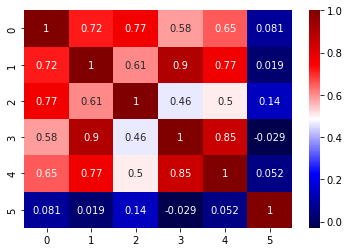

In [171]:
corrs = np.corrcoef([signals['Mmmyco'] for signals in [myco_pol_log, myco_pol_KL, pol2_myco_clip, myco_pol_ip, myco_pol_ip2, preds_m]])
sns.heatmap(corrs, cmap='seismic', annot=True)

,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.449050,0.449142,0.653600,0.655790
chrII,0.506007,0.505324,0.718132,0.719074
chrIII,0.475997,0.474129,0.732754,0.732164
chrIV,0.464192,0.464903,0.685400,0.687610
chrV,0.491082,0.489203,0.715117,0.713874
chrVI,0.460859,0.465063,0.681082,0.683498
chrVII,0.484060,0.483210,0.711544,0.710500
chrVIII,0.536789,0.538873,0.697672,0.700733
chrIX,0.504517,0.506402,0.701997,0.702621
chrX,0.498397,0.497596,0.698984,0.697740


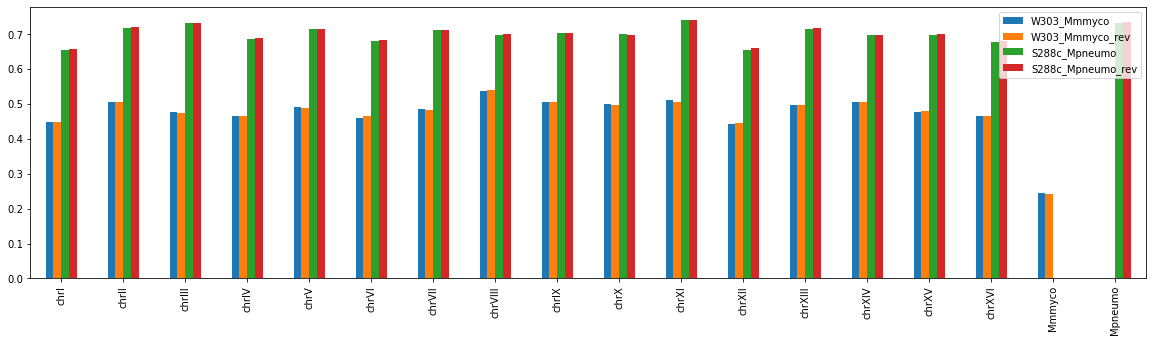

In [82]:
model_name = 'model_pneu_nuc_1'
df = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df.plot(kind='bar', figsize=(20, 5))
df

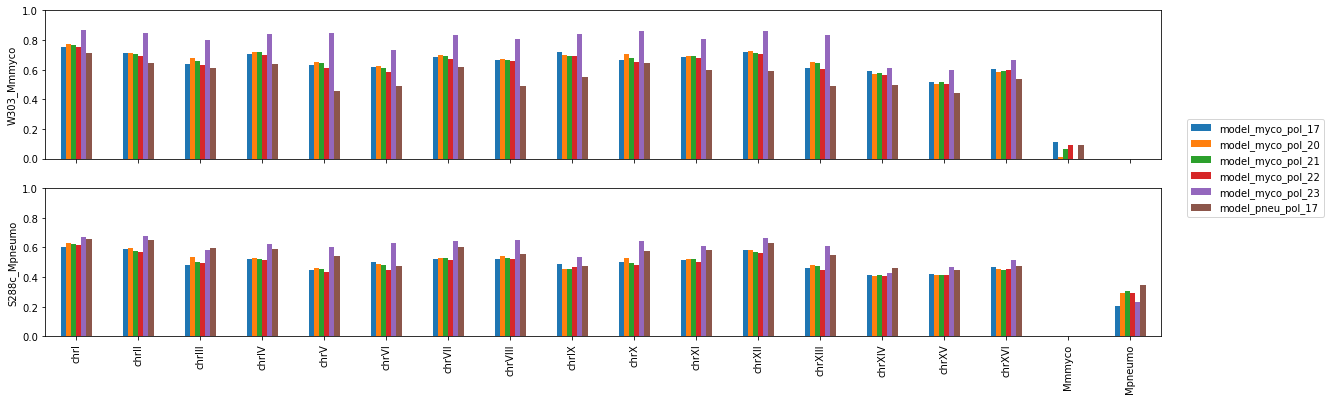

In [16]:
model_names = ['model_myco_pol_17', 'model_myco_pol_20', 'model_myco_pol_21', 'model_myco_pol_22', 'model_myco_pol_23', 'model_pneu_pol_17']
full_myco = pd.DataFrame(columns=model_names)
full_pneu = pd.DataFrame(columns=model_names)

for model_name in model_names:
    try:
        df = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_ratio'), index_col=0)
    except FileNotFoundError:
        df = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_log'), index_col=0)
    full_myco[model_name] = df['W303_Mmmyco']
    full_pneu[model_name] = df['S288c_Mpneumo']

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 6))
full_myco.plot(kind='bar', ax=axes[0], ylabel='W303_Mmmyco', legend=False)
full_pneu.plot(kind='bar', ax=axes[1], ylabel='S288c_Mpneumo', legend=False)
axes[0].set_ylim((0, 1))
plt.legend(bbox_to_anchor=(1.15, 1.5))

In [146]:
model_name = 'model_myco_pol_8'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs_KL = df1.join(df2, lsuffix='_KL')
df_corrs_KL

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.799840,0.801280,0.676309,0.667698,0.779627,0.787511,0.670065,0.672512
chrII,0.898482,0.902042,0.770078,0.794903,0.899436,0.898755,0.808349,0.825577
chrIII,0.849089,0.867195,0.706046,0.708691,0.846397,0.866259,0.725557,0.732952
chrIV,0.902434,0.891441,0.824209,0.824747,0.895263,0.882752,0.857704,0.856435
chrV,0.874346,0.872034,0.732983,0.756507,0.873666,0.871837,0.774326,0.793590
chrVI,0.839483,0.812629,0.632305,0.603186,0.830800,0.805986,0.664269,0.639030
chrVII,0.897031,0.903064,0.796474,0.791919,0.895411,0.896517,0.826487,0.822502
chrVIII,0.838437,0.856977,0.705015,0.717136,0.831348,0.848515,0.748703,0.762126
chrIX,0.839146,0.857319,0.718717,0.679691,0.824862,0.841291,0.734940,0.709954
chrX,0.893220,0.895622,0.794876,0.793698,0.885295,0.889121,0.820300,0.820397


In [ ]:
model_name = 'model_myco_pol_7'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs = df1.join(df2, lsuffix='_KL')
df_corrs

Compute GC content

In [6]:
gc_W303 = utils.GC_content(np.expand_dims(np.concatenate([v for k, v in one_hots_myco.items() if k!='Mmmyco']), axis=0))
gc_S288c = utils.GC_content(np.expand_dims(np.concatenate([v for k, v in one_hots_pneu.items() if k!='Mpneumo']), axis=0))
gc_myco = utils.GC_content(np.expand_dims(one_hots_myco['Mmmyco'], axis=0))
gc_pneu = utils.GC_content(np.expand_dims(one_hots_pneu['Mpneumo'], axis=0))    
print(gc_W303, gc_S288c, gc_myco, gc_pneu)

[0.38334965] [0.38297367] [0.24156089] [0.40010954]


Nucleosome distance

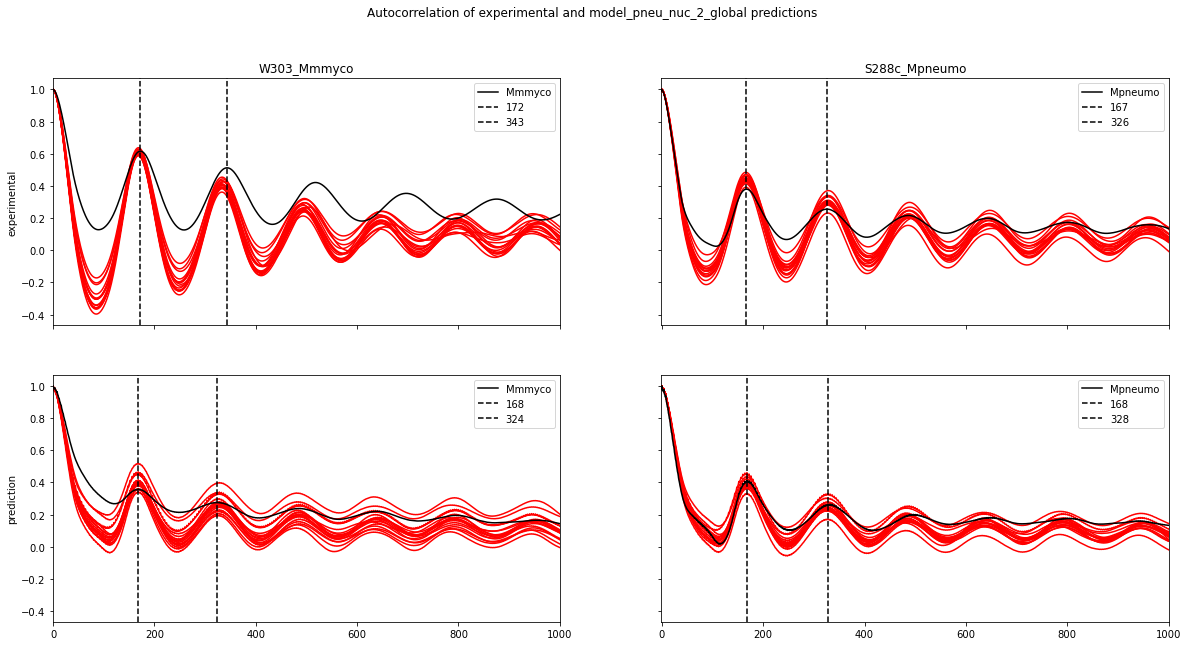

In [112]:
model_name = 'model_pneu_nuc_2_global'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_m = {k: fm[k] for k in fm.keys() if k[-4:] != '_rev'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_p = {k: fp[k] for k in fp.keys() if k[-4:] != '_rev' and k != 'Mito'}

fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(20, 10), facecolor='w')
fig.suptitle(f'Autocorrelation of experimental and {model_name} predictions')

for chr_id, signal in myco_nuc.items():
    centered_signal = signal - np.mean(signal)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode='full')
    lags = scipy.signal.correlation_lags(signal.size, signal.size, mode="full")
    corrs /= corrs[lags == 0]
    if chr_id[0] == 'M':
        axes[0, 0].plot(lags, corrs, label=chr_id, color='k')
        best_autocorr = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
        axes[0, 0].axvline(best_autocorr, color='k', linestyle='--', label=str(best_autocorr))
        autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
        axes[0, 0].axvline(autocorr2, color='k', linestyle='--', label=str(autocorr2))
    else:
        axes[0, 0].plot(lags, corrs, color='r')
axes[0, 0].legend(loc='upper right')

for chr_id, signal in pneu_nuc.items():
    centered_signal = signal - np.mean(signal)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode='full')
    lags = scipy.signal.correlation_lags(signal.size, signal.size, mode="full")
    corrs /= corrs[lags == 0]
    if chr_id[0] == 'M':
        axes[0, 1].plot(lags, corrs, label=chr_id, color='k')
        best_autocorr = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
        axes[0, 1].axvline(best_autocorr, color='k', linestyle='--', label=str(best_autocorr))
        autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
        axes[0, 1].axvline(autocorr2, color='k', linestyle='--', label=str(autocorr2))
    else:
        axes[0, 1].plot(lags, corrs, color='r')
axes[0, 1].legend(loc='upper right')

for chr_id, signal in preds_m.items():
    centered_signal = signal - np.mean(signal)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode='full')
    lags = scipy.signal.correlation_lags(signal.size, signal.size, mode="full")
    corrs /= corrs[lags == 0]
    if chr_id[0] == 'M':
        axes[1, 0].plot(lags, corrs, label=chr_id, color='k')
        best_autocorr = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
        axes[1, 0].axvline(best_autocorr, color='k', linestyle='--', label=str(best_autocorr))
        autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
        axes[1, 0].axvline(autocorr2, color='k', linestyle='--', label=str(autocorr2))
    else:
        axes[1, 0].plot(lags, corrs, color='r')
axes[1, 0].legend(loc='upper right')

for chr_id, signal in preds_p.items():
    centered_signal = signal - np.mean(signal)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode='full')
    lags = scipy.signal.correlation_lags(signal.size, signal.size, mode="full")
    corrs /= corrs[lags == 0]
    if chr_id[0] == 'M':
        axes[1, 1].plot(lags, corrs, label=chr_id, color='k')
        best_autocorr = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
        axes[1, 1].axvline(best_autocorr, color='k', linestyle='--', label=str(best_autocorr))
        autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
        axes[1, 1].axvline(autocorr2, color='k', linestyle='--', label=str(autocorr2))
    else:
        axes[1, 1].plot(lags, corrs, color='r')
axes[1, 1].legend(loc='upper right')

axes[0, 0].set_title('W303_Mmmyco')
axes[0, 1].set_title('S288c_Mpneumo')
axes[0, 0].set_ylabel('experimental')
axes[1, 0].set_ylabel('prediction')
axes[0, 0].set_xlim((-1, 1000))
# axes[0, 0].set_xlim((130, 230))
# axes[0, 0].set_ylim((0, 0.8))

outfile = utils.safe_filename(Path(data_dir, species, 'results', model_name, f'Autocorr_experimental_and_{model_name}_predictions.png'))
plt.savefig(outfile, bbox_inches='tight')

Predictions on random sequences

In [8]:
preds_nuc_rand_etienne = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds_coh_rand_etienne = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand_etienne = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_strictGCrange_indep_32.npy'))


In [46]:
preds_nuc_rand = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_v1_nucleosome_random_strictGCrange_indep_10000.npy'))
preds_coh_rand = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_14_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_17_pol_random_strictGCrange_indep_32.npy'))
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)

In [59]:
preds_coh_rand14 = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_14_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand14 = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_14_pol_random_strictGCrange_indep_32.npy'))
preds_pol_rand15 = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_15_pol_random_strictGCrange_indep_32.npy'))
preds_pol_rand16 = np.load(Path(data_dir, species, 'results', 'random_seqs', f'preds_myco_pneu_16_pol_random_strictGCrange_indep_32.npy'))

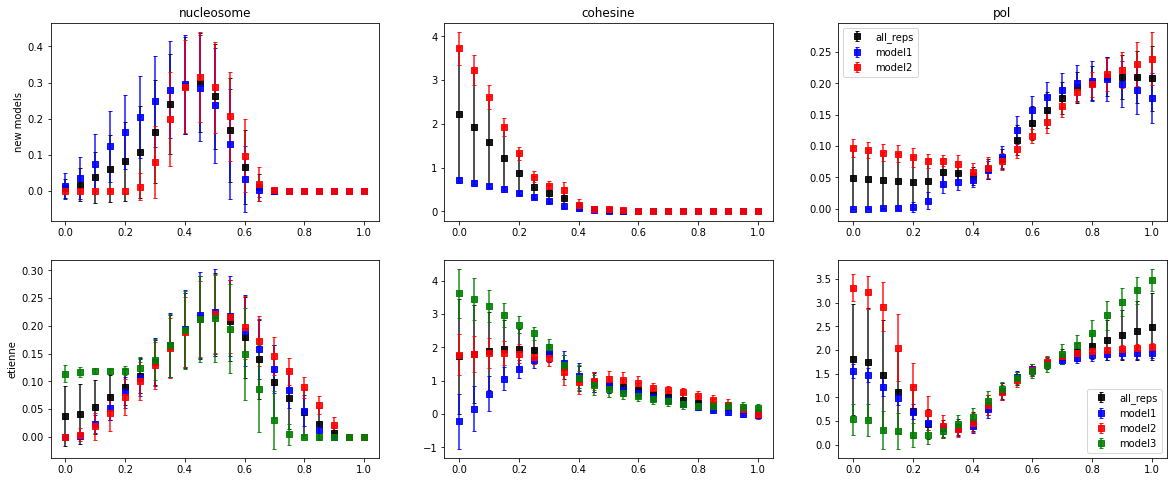

In [9]:
q_min, q_max = 0.1, 0.9
nrow = 2
ncol = 3
fmts = ['bs', 'rs', 'gs']
annots = ['nucleosome', 'cohesine', 'pol']
ylabels = ['new models', 'etienne']
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8), facecolor='w')
for col in range(ncol):
    axes[0, col].set_title(annots[col])
for row in range(nrow):
    if row == 0:
        preds_nuc, preds_coh, preds_pol = preds_nuc_rand, preds_coh_rand, preds_pol_rand
        n_reps = 2
    elif row == 1:
        preds_nuc, preds_coh, preds_pol = preds_nuc_rand_etienne, preds_coh_rand_etienne, preds_pol_rand_etienne
        n_reps = 3
    for col, preds in enumerate([preds_nuc, preds_coh, preds_pol]):
        axes[row, col].errorbar(gcs, y=preds.mean(axis=1), yerr=preds.std(axis=1), fmt='ks', alpha=0.9, label='all_reps', capsize=2)
        means = preds.reshape(n_gcs, n_reps, -1).mean(axis=2)
        stds = preds.reshape(n_gcs, n_reps, -1).std(axis=2)
        for i in range(n_reps):
            axes[row, col].errorbar(gcs, y=means[:, i], yerr=stds[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
        # if row == 0 and col == 2:
        #     axes[row, col].errorbar(gcs, y=preds_pol_rand16.mean(axis=1), yerr=preds_pol_rand16.std(axis=1), fmt='ks', alpha=0.9, label='all_reps 2', capsize=2)
        #     means = preds_pol_rand16.reshape(n_gcs, n_reps, -1).mean(axis=2)
        #     stds = preds_pol_rand16.reshape(n_gcs, n_reps, -1).std(axis=2)
        #     for i in range(n_reps):
        #         axes[row, col].errorbar(gcs, y=means[:, i], yerr=stds[:, i], fmt='s', alpha=0.9, label=f'model{i+1+2}', capsize=2)
    axes[row, 0].set_ylabel(ylabels[row])
    axes[row, col].legend()
# axes[0, 1].set_ylim((-0.05, 0.2))

Load predictions

In [44]:
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'labels_myco_nuc.npz')) as f:
    labels_nuc = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'labels_pneu_nuc.npz')) as f:
    labels_nuc.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_coh_ratio.npz')) as f:
    labels_coh = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_coh_ratio.npz')) as f:
    labels_coh.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_pol_ratio.npz')) as f:
    labels_pol = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol_ratio.npz')) as f:
    labels_pol.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_nuc_2', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_nuc_myco = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_nuc_2', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_nuc_myco.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_nuc_2', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_nuc_pneu = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_nuc_2', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_nuc_pneu.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_coh_14', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_coh_myco = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_coh_14', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_coh_myco.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_coh_14', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_coh_pneu = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_coh_14', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_coh_pneu.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_pol_17', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_pol_myco = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_myco_pol_17', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_pol_myco.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_pol_17', 'preds_on_W303_Mmmyco.npz')) as f:
    preds_pol_pneu = {k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'}
with np.load(Path(data_dir, 'SCerevisiae', 'results', 'model_pneu_pol_17', 'preds_on_S288c_Mpneumo.npz')) as f:
    preds_pol_pneu.update({k: f[k] for k in f.keys() if k[-4:] != '_rev' and k != 'Mito'})

In [45]:
one_hots_yeast = {k: v for k, v in one_hots_myco.items() if k!='Mmmyco'}
one_hots_yeast.update({k: v for k, v in one_hots_pneu.items() if k!='Mpneumo'})
one_hot_myco = one_hots_myco['Mmmyco']
one_hot_pneu = one_hots_pneu['Mpneumo']

In [48]:
def window_summary(one_hot, signals, binsize, on, ks=[2, 1], includeN=True):
    if on == 'yeast':
        window_one_hot, window_signals = {}, {}
        for key, oh in one_hot.items():
            if key[:3] == 'chr': # True: #
                window_one_hot[key] = utils.chunk_regions(oh, binsize)
                window_signals[key] = utils.chunk_regions(np.vstack([signal[key] for signal in signals.values()]).T, binsize).mean(axis=1)
        window_one_hot = np.concatenate(list(window_one_hot.values()), axis=0)
        window_signals = np.concatenate(list(window_signals.values()), axis=0)
    else:
        window_one_hot = utils.chunk_regions(one_hot, binsize)
        window_signals = utils.chunk_regions(np.vstack([signal[on] for signal in signals.values()]).T, binsize).mean(axis=1)
    if not includeN:
        noN_mask = np.sum(window_one_hot, axis=(1, 2)) == binsize
        window_one_hot = window_one_hot[noN_mask]
        window_signals = window_signals[noN_mask]
    window_df = pd.concat([pd.DataFrame(utils.GC_content(window_one_hot), columns=['gc']),
                           pd.DataFrame(window_signals, columns=signals.keys())],
                          axis=1)
    window_kmers = {}
    for k in ks:
        window_kmers[k] = utils.kmer_counts_by_seq(window_one_hot, k, includeN=includeN)
    return window_df, window_one_hot, window_kmers

def sliding_summary(one_hot, signals, winsize, on, ks=[2, 1], includeN=True):
    if on == 'yeast':
        sliding_signals, sliding_gc, sliding_noN_mask = {}, {}, {}
        sliding_kmers = {k:{} for k in ks}
        for key, oh in one_hot.items():
            if key[:3] == 'chr': # True: #
                sliding_signals[key] = np.vstack([signal[key] for signal in signals.values()]).T[(winsize - 1) // 2:-(winsize // 2)]
                sliding_gc[key] = utils.sliding_GC(oh, winsize)
                sliding_gc[key][~np.isfinite(sliding_gc[key])] = 0.38
                sliding_noN_mask[key] = utils.moving_sum(oh, winsize, axis=0).sum(axis=1) == winsize
                for k in ks:
                    sliding_kmers[k][key] = utils.sliding_kmer_counts(oh, k, winsize, includeN=includeN)
        sliding_signals = np.concatenate(list(sliding_signals.values()), axis=0)
        sliding_gc = np.concatenate(list(sliding_gc.values()), axis=0)
        sliding_noN_mask = np.concatenate(list(sliding_noN_mask.values()), axis=0)
        for k in ks:
            sliding_kmers[k] = pd.concat(list(sliding_kmers[k].values()), axis=1)
    else:
        sliding_signals = np.vstack([signal[on] for signal in signals.values()]).T[(winsize - 1) // 2:-(winsize // 2)]
        sliding_gc = utils.sliding_GC(one_hot, winsize)
        sliding_noN_mask = utils.moving_sum(one_hot, winsize, axis=0).sum(axis=1) == winsize
        sliding_kmers = {}
        for k in ks:
            sliding_kmers[k] = utils.sliding_kmer_counts(one_hot, k, winsize, includeN=includeN)
    if not includeN:
        sliding_signals = sliding_signals[sliding_noN_mask]
        sliding_gc = sliding_gc[sliding_noN_mask]
        for k in ks:
            sliding_kmers[k] = sliding_kmers[k].loc[:, sliding_noN_mask]
    sliding_df = pd.concat([pd.DataFrame(sliding_gc, columns=['gc']),
                            pd.DataFrame(sliding_signals, columns=signals.keys())],
                           axis=1)
    return sliding_df, sliding_kmers

def linear_models(window_df, window_kmers, label_names, gc=True, ref_models=None):
    results = {}
    models = {}
    data = {f'{k}mer_{label}': (kmers.T.to_numpy() / (101 - k), window_df[label])
            for k, kmers in window_kmers.items() for label in label_names}
    if gc:
        for label in label_names:
            data[f'gc_{label}'] = (sm.tools.add_constant(window_df['gc'].to_numpy()), window_df[label])
            data[f'gc_quad_{label}'] = (sm.tools.add_constant(np.vstack([window_df['gc'].to_numpy(), window_df['gc'].to_numpy()**2]).T), window_df[label])
    for name, (X, Y) in data.items():
        mod = sm.OLS(Y, X)
        model = mod.fit()
        model_name = f'lm_{name}'
        models[model_name] = model
        results[model_name] = model.predict(X)
        if ref_models is not None:
            for ref_name in ref_models.keys():
                results[f'{model_name}_mod_{ref_name}'] = ref_models[ref_name][model_name].predict(X)
    return pd.concat([window_df, pd.DataFrame(results)], axis=1), models

def kmer_analysis_wrapper(one_hot, signals, binsizes, on, winsizes=[2001], ks=[2, 1], includeN=True, gc=True, ref_models=None):
    print(on)
    results = {}
    for winsize in winsizes:
        print(winsize)
        if ref_models is None:
            ref_models_winsize = None
        else:
            ref_models_winsize = ref_models[winsize]
        sliding_df, sliding_kmers = sliding_summary(one_hot, signals, winsize, on, ks, includeN)
        # window_kmers = {k: window_kmer for k, window_kmer in zip(ks, window_kmers)}
        label_names = ['lab_nuc', 'lab_coh', 'lab_pol']
        sliding_df, models = linear_models(sliding_df, sliding_kmers, label_names, gc, ref_models_winsize)
        sliding_df_smooth = {}
        for binsize in binsizes:
            print(binsize)
            sliding_df_smooth[binsize] = sliding_df.copy()
            for column in sliding_df.columns[1:]:
                sliding_df_smooth[binsize][column] = utils.smooth(sliding_df[column], binsize)
        results[winsize] = (sliding_df, sliding_df_smooth, sliding_kmers, models)
    if len(results) == 1:
        return results[winsize]
    else:
        return results

def seperate_low_high(window_gc, window_values, div=2):
    # Sort values by pred value
    sort_idx = np.argsort(window_values)
    sorted_gc = window_gc[sort_idx]
    # Create mask of values to take as low or high
    low_mask = np.zeros(len(sorted_gc), dtype=bool)
    high_mask = np.zeros(len(sorted_gc), dtype=bool)
    for gc, count in zip(*np.unique(window_gc, return_counts=True)):
        if count < div:
            continue
        gc_idxes = (sorted_gc == gc).nonzero()[0]
        low_mask[gc_idxes[:count // div]] = 1
        high_mask[gc_idxes[-(count // div):]] = 1
    # Reverse sort the mask
    revsort_idx = sort_idx.argsort()
    return low_mask[revsort_idx], high_mask[revsort_idx]

def seperate_3(window_gc, window_values):
    # Sort values by pred value
    sort_idx = np.argsort(window_values)
    sorted_gc = window_gc[sort_idx]
    # Create mask of values to take as low or high
    low_mask = np.zeros(len(sorted_gc), dtype=bool)
    mid_mask = np.zeros(len(sorted_gc), dtype=bool)
    high_mask = np.zeros(len(sorted_gc), dtype=bool)
    for gc, count in zip(*np.unique(window_gc, return_counts=True)):
        if count < 3:
            continue
        gc_idxes = (sorted_gc == gc).nonzero()[0]
        low_mask[gc_idxes[:count // 3]] = 1
        mid_mask[gc_idxes[count // 3 : -(count // 3)]] = 1
        high_mask[gc_idxes[-(count // 3):]] = 1
    # Reverse sort the mask
    revsort_idx = sort_idx.argsort()
    return low_mask[revsort_idx], mid_mask[revsort_idx], high_mask[revsort_idx]

In [44]:
del results_yeast, sliding_yeast, sliding_yeast_smooth, sliding_kmers_yeast, models_yeast
del results_myco, sliding_myco, sliding_myco_smooth, sliding_kmers_myco, models_myco
del results_pneu, sliding_pneu, sliding_pneu_smooth, sliding_kmers_pneu, models_pneu

In [49]:
winsizes = [2001]
binsizes = [10, 100, 1000, 2001]
ks = [2, 1] # [] #
signals = {
    'lab_nuc': labels_nuc,
    'lab_coh': labels_coh,
    'lab_pol': labels_pol,
    'pred_nuc_myco': preds_nuc_myco,
    'pred_coh_myco': preds_coh_myco,
    'pred_pol_myco': preds_pol_myco,
    'pred_nuc_pneu': preds_nuc_pneu,
    'pred_coh_pneu': preds_coh_pneu,
    'pred_pol_pneu': preds_pol_pneu,
}
results_yeast = kmer_analysis_wrapper(one_hots_yeast, signals, binsizes, 'yeast', ks=ks, winsizes=winsizes)
models_yeast = {winsizes[0]: {'yeast': results_yeast[3]}}
results_myco = kmer_analysis_wrapper(one_hot_myco, signals, binsizes, 'Mmmyco', ks=ks, winsizes=winsizes, ref_models=models_yeast)
results_pneu = kmer_analysis_wrapper(one_hot_pneu, signals, binsizes, 'Mpneumo', ks=ks, winsizes=winsizes, ref_models=models_yeast)
sliding_yeast, sliding_yeast_smooth, sliding_kmers_yeast, models_yeast = results_yeast
sliding_myco, sliding_myco_smooth, sliding_kmers_myco, models_myco = results_myco
sliding_pneu, sliding_pneu_smooth, sliding_kmers_pneu, models_pneu = results_pneu
sliding_yeast

yeast
2001


/home/alex/mnhn-internship_DeepCNN_ChIP-seq/Modules/utils.py:942: RuntimeWarning: invalid value encountered in true_divide
  return moving_sum(GC_mask, n=n) / moving_sum(valid_mask, n=n)


10
100
1000
2001
Mmmyco
2001
10
100
1000
2001
Mpneumo
2001
10
100
1000
2001


,gc,lab_nuc,lab_coh,lab_pol,pred_nuc_myco,pred_coh_myco,pred_pol_myco,pred_nuc_pneu,pred_coh_pneu,pred_pol_pneu,...,lm_2mer_lab_pol,lm_1mer_lab_nuc,lm_1mer_lab_coh,lm_1mer_lab_pol,lm_gc_lab_nuc,lm_gc_quad_lab_nuc,lm_gc_lab_coh,lm_gc_quad_lab_coh,lm_gc_lab_pol,lm_gc_quad_lab_pol
0,0.408296,0.791328,0.318952,0.012203,0.244380,0.242831,0.066014,0.115836,0.492710,0.080914,...,0.134888,0.270697,0.092894,0.121673,0.274128,0.280820,0.094934,0.088700,0.130672,0.132289
1,0.408796,0.807588,0.319325,0.015227,0.170997,0.265544,0.066844,0.082906,0.436513,0.076361,...,0.133506,0.270617,0.092143,0.122031,0.274031,0.280584,0.094180,0.088076,0.131003,0.132585
2,0.408796,0.815718,0.317405,0.015135,0.175799,0.327679,0.072515,0.000000,0.474423,0.075129,...,0.134109,0.270617,0.092143,0.122031,0.274031,0.280584,0.094180,0.088076,0.131003,0.132585
3,0.408796,0.826558,0.316929,0.015113,0.064474,0.295932,0.077686,0.000000,0.443613,0.076570,...,0.133218,0.270632,0.092140,0.122031,0.274031,0.280584,0.094180,0.088076,0.131003,0.132585
4,0.408796,0.823848,0.313378,0.014943,0.308203,0.302281,0.073954,0.074710,0.537371,0.076422,...,0.132678,0.270651,0.092152,0.122082,0.274031,0.280584,0.094180,0.088076,0.131003,0.132585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157789,0.341329,0.653117,0.147492,0.042407,0.331484,0.125532,0.041690,0.211389,0.464746,0.076433,...,0.097282,0.287114,0.196127,0.085508,0.287092,0.270316,0.195960,0.211586,0.086421,0.082368
12157790,0.340830,0.666667,0.147182,0.043290,0.334181,0.131844,0.031325,0.243175,0.620070,0.066456,...,0.096678,0.287194,0.196879,0.085150,0.287189,0.269924,0.196714,0.212795,0.086090,0.081920
12157791,0.340330,0.691057,0.142508,0.045498,0.353615,0.142846,0.040001,0.206991,0.577536,0.062967,...,0.095964,0.287308,0.197640,0.084844,0.287285,0.269527,0.197468,0.214009,0.085760,0.081471
12157792,0.340330,0.685637,0.142340,0.045444,0.282761,0.120211,0.045313,0.215060,0.631683,0.069554,...,0.095085,0.287308,0.197640,0.084844,0.287285,0.269527,0.197468,0.214009,0.085760,0.081471


In [11]:
div = 3
seps = np.array(['discarded', 'low', 'high', 'mid'])
yeast_seps = {}
myco_seps = {}
pneu_seps = {}
for binsize in [100, 2001]:
    print(binsize)
    for part1 in ['lab', 'pred']:
        for part2 in ['nuc', 'coh', 'pol']:
            annot = f'{part1}_{part2}'
            if part1 == 'pred':
                annot += '_myco'
            yeast_seps[f'sep_{annot}'] = np.array(['discarded']*len(sliding_yeast_smooth[binsize]))
            low_mask, mid_mask, high_mask = seperate_3(sliding_yeast_smooth[binsize]['gc'].to_numpy(), sliding_yeast_smooth[binsize][annot].to_numpy())
            yeast_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

            myco_seps[f'sep_{annot}'] = np.array(['discarded']*len(sliding_myco_smooth[binsize]))
            low_mask, mid_mask, high_mask = seperate_3(sliding_myco_smooth[binsize]['gc'].to_numpy(), sliding_myco_smooth[binsize][annot].to_numpy())
            myco_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

            pneu_seps[f'sep_{annot}'] = np.array(['discarded']*len(sliding_pneu_smooth[binsize]))
            low_mask, mid_mask, high_mask = seperate_3(sliding_pneu_smooth[binsize]['gc'].to_numpy(), sliding_pneu_smooth[binsize][annot].to_numpy())
            pneu_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]
    print('saving')        
    try:
        sliding_yeast_smooth[binsize] = sliding_yeast_smooth[binsize].join(pd.DataFrame(yeast_seps))
        sliding_myco_smooth[binsize] = sliding_myco_smooth[binsize].join(pd.DataFrame(myco_seps))
        sliding_pneu_smooth[binsize] = sliding_pneu_smooth[binsize].join(pd.DataFrame(pneu_seps))
    except ValueError:
        sliding_yeast_smooth[binsize].loc[:, list(yeast_seps.keys())] = pd.DataFrame(yeast_seps)
        sliding_myco_smooth[binsize].loc[:, list(myco_seps.keys())] = pd.DataFrame(myco_seps)
        sliding_pneu_smooth[binsize].loc[:, list(pneu_seps.keys())] = pd.DataFrame(pneu_seps)

100
saving
2001
saving


(0.0, 1.0)

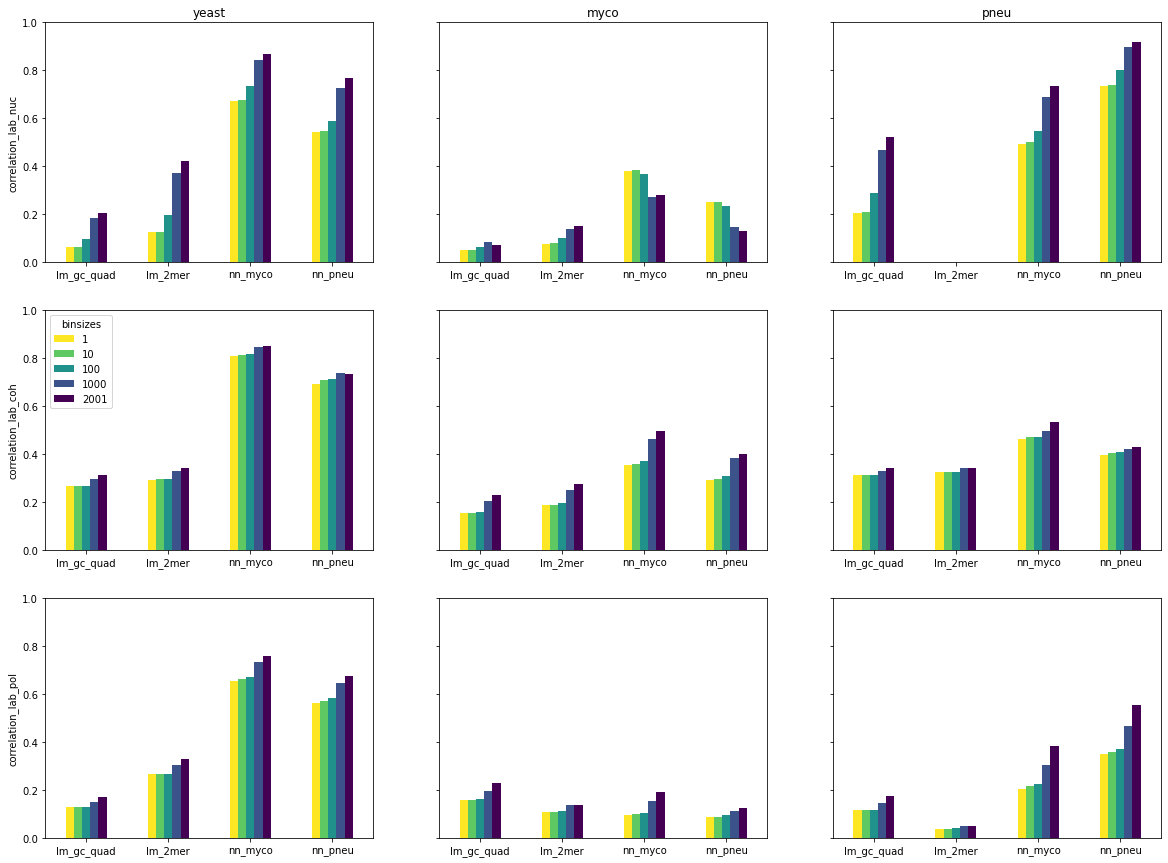

In [50]:
genomes = ['yeast', 'myco', 'pneu']
fig, axes = plt.subplots(3, 3, sharey=True, figsize=(20, 15), facecolor='w')
for i, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    for j, results in enumerate([results_yeast, results_myco, results_pneu]):
        axes[0, j].set_title(genomes[j])
        modsuf = ''
        if j > 0:
            modsuf = '_mod_yeast'
        sliding_df, sliding_df_smooth, *_ = results
        cpt = 0
        plot_df = pd.DataFrame(index=['lm_gc_quad', 'lm_2mer', 'nn_myco', 'nn_pneu'])
        for binsize, df in [(1, sliding_df)] + list(sliding_df_smooth.items()):
            corrs_mod_yeast = utils.lineWiseCorrcoef(
                df.loc[:, [
                    # f'lm_gc_{annot}{modsuf}',
                    f'lm_gc_quad_{annot}{modsuf}',
                    # f'lm_1mer_{annot}{modsuf}',
                    f'lm_2mer_{annot}{modsuf}',
                    f'pred_{annot[-3:]}_myco',
                    f'pred_{annot[-3:]}_pneu']
                ].T.to_numpy(),
                df[annot].to_numpy())
            plot_df[binsize] = corrs_mod_yeast
        plot_df.plot.bar(color=mpl.cm.get_cmap('viridis', len(plot_df.columns)).colors[::-1],
                         ax=axes[i, j], legend=False, rot=0)
        cpt += 1
    axes[i, 0].set_ylabel(f'correlation_{annot}')
axes[1, 0].legend(title='binsizes')
axes[0, 0].set_ylim((0, 1))
# plot_utils.save_fig_and_values(fig, Path(data_dir, species, 'results', 'kmers', f'corrvalues_alllabels_mycopneumodels2-14-17_sliding_{winsizes[0]}'))

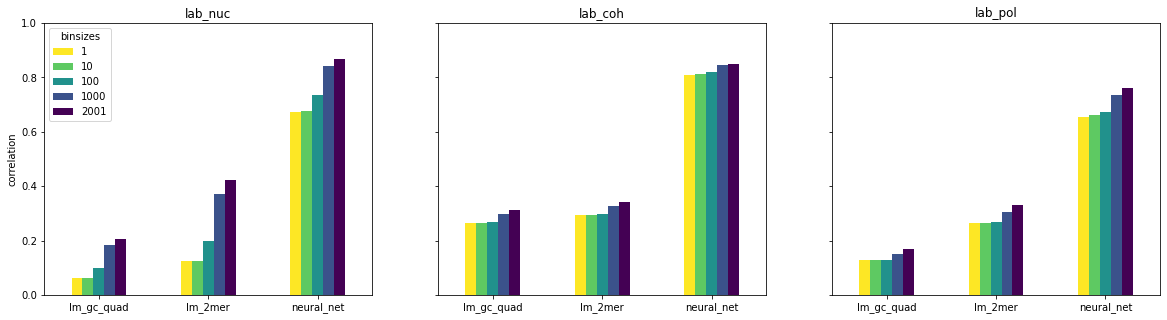

In [117]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5), facecolor='w')
for j, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    axes[j].set_title(annot)
    plot_df = pd.DataFrame(index=['lm_gc_quad', 'lm_2mer', 'neural_net'])
    binsizes = [1] + list(sliding_yeast_smooth.keys())
    # df_tuple_list = [(sliding_yeast, sliding_myco, sliding_pneu)] + [
    #     (sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]) for binsize in binsizes[1:]]
    df_tuple_list = [(sliding_yeast, )] + [
        (sliding_yeast_smooth[binsize], ) for binsize in binsizes[1:]]
    for binsize, df_tuple in zip(binsizes, df_tuple_list):
        corrs_mod_yeast = utils.lineWiseCorrcoef(
            np.concatenate([
                df.loc[:, [f'lm_gc_quad_{annot}{modsuf}', f'lm_2mer_{annot}{modsuf}', f'pred_{annot[-3:]}_myco']].T.to_numpy()
                for df, modsuf in zip(df_tuple, ['', '_mod_yeast', '_mod_yeast'])
            ], axis=1),
            np.concatenate([
                df[annot].to_numpy()
                for df in df_tuple
            ])
            )
        plot_df[binsize] = corrs_mod_yeast
    plot_df.plot.bar(color=mpl.cm.get_cmap('viridis', len(plot_df.columns)).colors[::-1],
                        ax=axes[j], legend=False, rot=0)
axes[0].set_ylabel('correlation')
axes[0].legend(title='binsizes')
axes[0].set_ylim((0, 1))
plot_utils.save_fig_and_values(fig, Path(data_dir, species, 'results', 'kmers', f'corrvalues_alllabels_merged_mycopneumodels2-14-17_sliding_{winsizes[0]}'))

Text(0.5, 0.98, 'binsize 100')

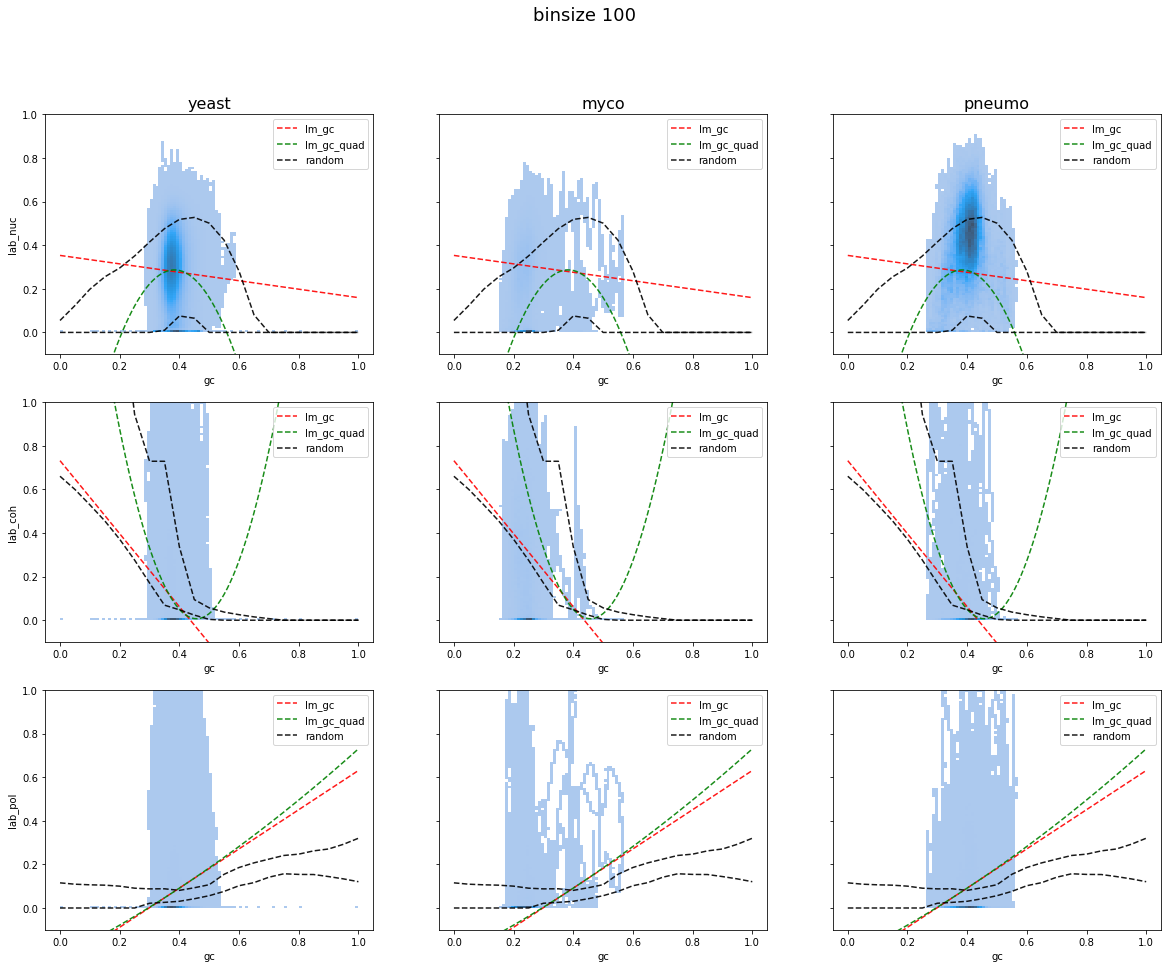

In [15]:
binsize = 100
if binsize == 1:
    df_list = [sliding_yeast, sliding_myco, sliding_pneu]
else:
    df_list = [sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]]
fig, axes = plt.subplots(3, 3, sharey='row', figsize=(20, 15), facecolor='w')
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for i, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    if annot == 'lab_nuc':
        rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
    elif annot == 'lab_coh':
        rand_preds = preds_coh_rand.reshape(n_gcs, -1)
    elif annot == 'lab_pol':
        rand_preds = preds_pol_rand.reshape(n_gcs, -1)
    else:
        raise ValueError(f"annot can't be {annot}")
    qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
    for j, df in enumerate(df_list):
        sns.histplot(data=df, x='gc', y=annot, binwidth=(0.01, 0.01),
                    label='experimental', ax=axes[i, j])
        hist_gcs = np.arange(0, 1.005, 0.01)
        # axes[i, j].plot(hist_gcs, models_yeast[f'lm_gc_{annot}'].predict(sm.tools.add_constant(hist_gcs)),
        #                 color='r', linestyle='--', alpha=0.9, label='lm_gc')
        # axes[i, j].plot(hist_gcs, models_yeast[f'lm_gc_quad_{annot}'].predict(sm.tools.add_constant(np.vstack([hist_gcs, hist_gcs**2]).T)),
        #                 color='g', linestyle='--', alpha=0.9, label='lm_gc_quad')
        axes[i, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
        axes[i, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
        axes[i, j].legend(loc='upper right').set_title('')
    axes[i, 0].set_ylabel(annot)
    # if annot in ['lab_nuc', 'lab_coh']:
    #     axes[i, 0].set_ylim(top=0.4)
    #     axes[i, 0].set_ylim(bottom=-0.01)
    # else:
    axes[i, 0].set_ylim(bottom=-0.1, top=1)
fig.suptitle(f'binsize {binsize}', fontsize=18)

Text(0.5, 0.98, 'binsize 100')

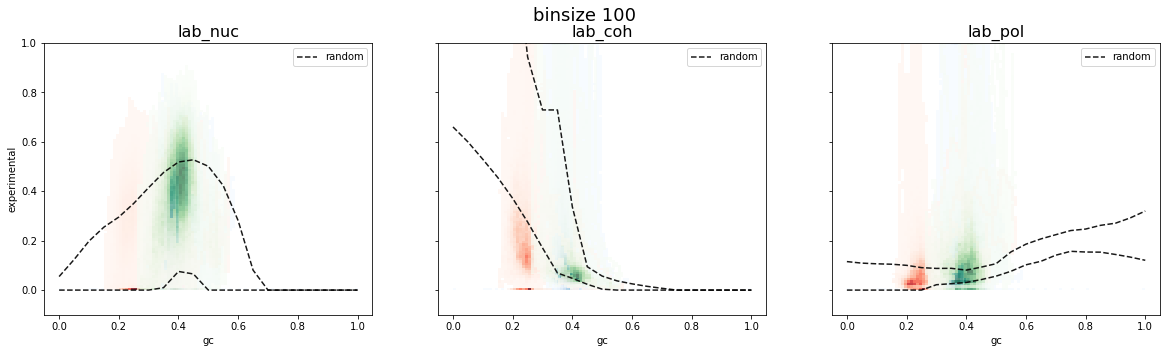

In [145]:
binsize = 100
if binsize == 1:
    df_list = [sliding_yeast, sliding_myco, sliding_pneu]
else:
    df_list = [sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]]
fig, axes = plt.subplots(1, 3, sharey='row', figsize=(20, 5), facecolor='w')
for j, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    axes[j].set_title(annot, fontsize=16)
    if annot == 'lab_nuc':
        rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
    elif annot == 'lab_coh':
        rand_preds = preds_coh_rand.reshape(n_gcs, -1)
    elif annot == 'lab_pol':
        rand_preds = preds_pol_rand.reshape(n_gcs, -1)
    else:
        raise ValueError(f"annot can't be {annot}")
    qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
    cmaps = ['Blues', 'Reds', 'Greens']
    alphas= [1, 0.8, 0.6]
    for df, cmap, alpha in zip(df_list, cmaps, alphas):
        sns.histplot(data=df, x='gc', y=annot, binwidth=(0.01, 0.01),
                     label='experimental', ax=axes[j], cmap=cmap, alpha=alpha)
    hist_gcs = np.arange(0, 1.005, 0.01)
    axes[j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
    axes[j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
    axes[j].legend(loc='upper right').set_title('')
axes[0].set_ylabel('experimental')
axes[0].set_ylim(bottom=-0.1, top=1)
fig.suptitle(f'binsize {binsize}', fontsize=18)

Text(0.5, 0.98, 'binsize 1')

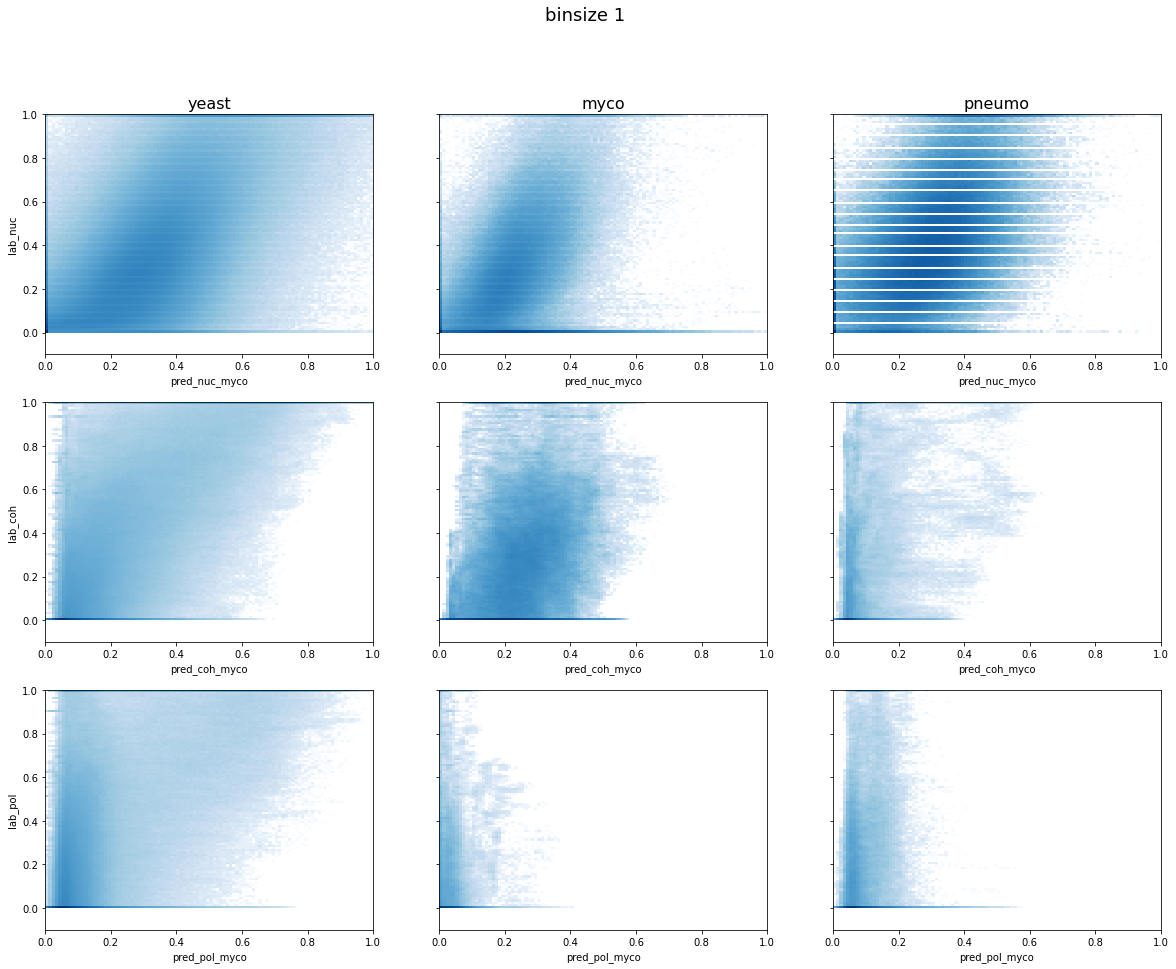

In [34]:
binsize = 1
if binsize == 1:
    df_list = [sliding_yeast, sliding_myco, sliding_pneu]
else:
    df_list = [sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]]
fig, axes = plt.subplots(3, 3, sharey='row', figsize=(20, 15), facecolor='w')
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for i, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    for j, df in enumerate(df_list):
        axes[i, j].hist2d(df[f'pred_{annot[-3:]}_myco'], df[annot], bins=100, range=((0, 1), (0, 1)),
                          cmap='Blues', norm=mpl.colors.LogNorm())
        axes[i, j].set_xlabel(f'pred_{annot[-3:]}_myco')
    axes[i, 0].set_ylabel(annot)
    # if annot in ['lab_nuc', 'lab_coh']:
    #     axes[i, 0].set_ylim(top=0.4)
    #     axes[i, 0].set_ylim(bottom=-0.01)
    # else:
    axes[i, 0].set_ylim(bottom=-0.1, top=1)
fig.suptitle(f'binsize {binsize}', fontsize=18)

Text(0.5, 0.98, 'binsize 2001')

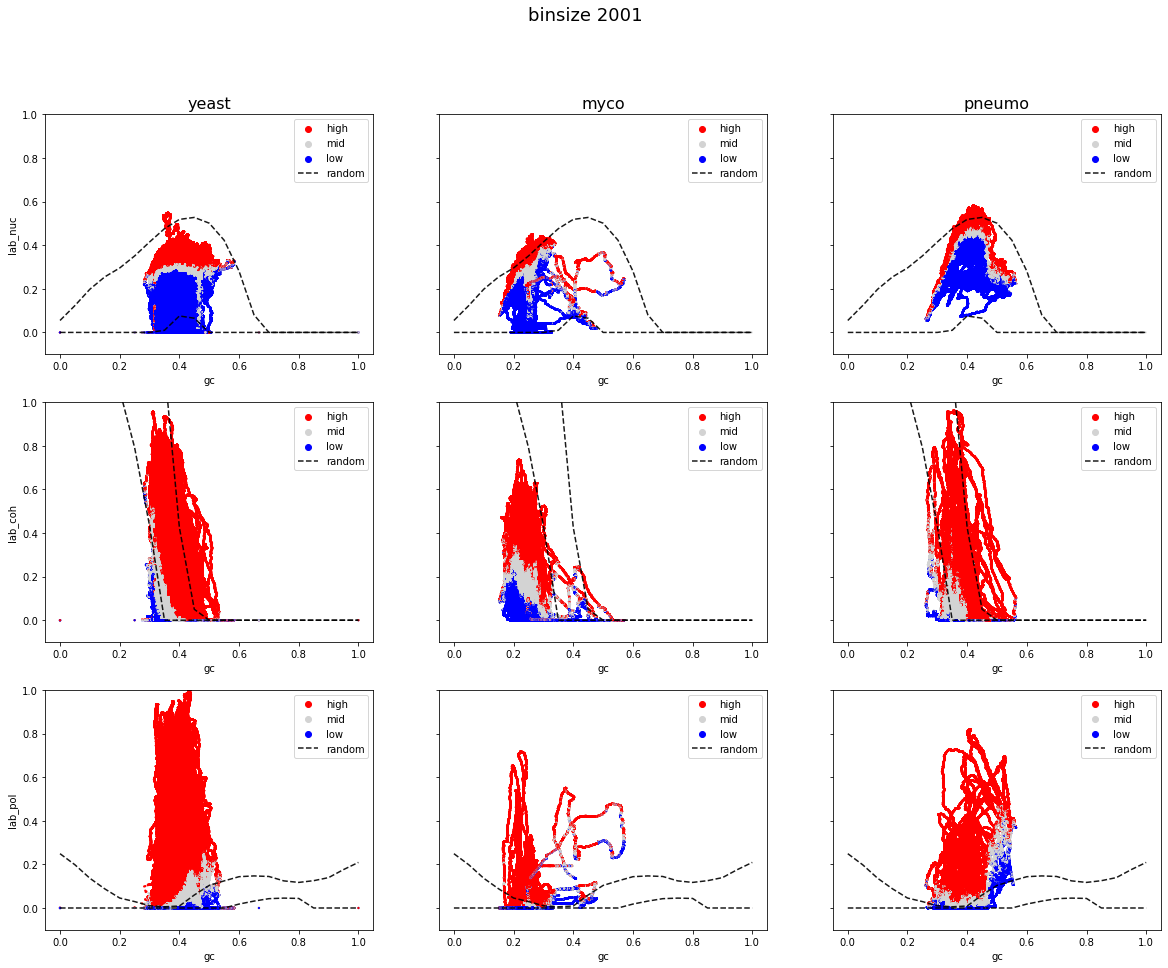

In [18]:
binsize = 2001
if binsize == 1:
    df_list = [sliding_yeast, sliding_myco, sliding_pneu]
else:
    df_list = [sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]]
fig, axes = plt.subplots(3, 3, sharey='row', figsize=(20, 15), facecolor='w')
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for i, annot in enumerate(['lab_nuc', 'lab_coh', 'lab_pol']):
    if annot == 'lab_nuc':
        rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
    elif annot == 'lab_coh':
        rand_preds = preds_coh_rand.reshape(n_gcs, -1)
    elif annot == 'lab_pol':
        rand_preds = preds_pol_rand.reshape(n_gcs, -1)
    else:
        raise ValueError(f"annot can't be {annot}")
    qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
    for j, df in enumerate(df_list):
        if j == 0:
            modsuf = ''
        else:
            modsuf = '_mod_yeast'
        sns.scatterplot(data=df.loc[df[f'sep_{annot}'] != 'discarded', :].loc[:, :], x='gc', y=annot,
                        hue=f'sep_{annot}', hue_order=['high', 'mid', 'low'], palette=['r', 'lightgray', 'b'],
                        ec=None, s=5, ax=axes[i, j])
        axes[i, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
        axes[i, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
        axes[i, j].legend(loc='upper right').set_title('')
    axes[i, 0].set_ylabel(annot)
    # if annot in ['lab_nuc', 'lab_coh']:
    #     axes[i, 0].set_ylim(top=0.4)
    #     axes[i, 0].set_ylim(bottom=-0.01)
    # else:
    axes[i, 0].set_ylim(bottom=-0.1, top=1)
fig.suptitle(f'binsize {binsize}', fontsize=18)

In [ ]:
annot = 'lab_pol'
binsize = 100
if binsize == 1:
    df_list = [sliding_yeast, sliding_myco, sliding_pneu]
else:
    df_list = [sliding_yeast_smooth[binsize], sliding_myco_smooth[binsize], sliding_pneu_smooth[binsize]]
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 10), facecolor='w')
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
if annot == 'lab_nuc':
    rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
elif annot == 'lab_coh':
    rand_preds = preds_coh_rand.reshape(n_gcs, -1)
elif annot == 'lab_pol':
    rand_preds = preds_pol_rand.reshape(n_gcs, -1)
else:
    raise ValueError(f"annot can't be {annot}")
qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
for j, df in enumerate(df_list):
    if j == 0:
        modsuf = ''
    else:
        modsuf = '_mod_yeast'
    sns.scatterplot(data=df.loc[df[f'sep_{annot}'] != 'discarded', :].loc[50::100, :], x='gc', y=annot,
                    hue=f'sep_{annot}', hue_order=['high', 'mid', 'low'], palette=['r', 'lightgray', 'b'],
                    ec=None, s=5, ax=axes[0, j])
    axes[0, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
    axes[0, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
    axes[0, j].legend(loc='upper right').set_title('')

    sns.scatterplot(data=df.loc[df[f'sep_pred_{annot[-3:]}_myco'] != 'discarded', :].loc[50::100, :], x='gc', y=f'pred_{annot[-3:]}3',
                    hue=f'sep_pred_{annot[-3:]}3', hue_order=['high', 'mid', 'low'], palette=['r', 'lightgray', 'b'],
                    ec=None, s=5, ax=axes[1, j])
    axes[1, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
    axes[1, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
    axes[1, j].legend(loc='upper right').set_title('')
axes[0, 0].set_ylabel('experimental')
axes[1, 0].set_ylabel('prediction')
if annot in ['lab_nuc', 'lab_coh']:
    axes[0, 0].set_ylim(top=0.4)
    axes[0, 0].set_ylim(bottom=-0.01)
else:
    axes[0, 0].set_ylim(bottom=-0.1)
fig.suptitle(f'{annot} with binsize {binsize}', fontsize=18)

In [130]:
def window_summary(one_hot, signals, binsize, on, ks=[2, 1], includeN=True):
    if on == 'yeast':
        window_one_hot, window_signals = {}, {}
        for key, oh in one_hot.items():
            if True: # key[:3] == 'chr':
                window_one_hot[key] = utils.chunk_regions(oh, binsize)
                window_signals[key] = utils.chunk_regions(np.vstack([signal[key] for signal in signals.values()]).T, binsize).mean(axis=1)
        window_one_hot = np.concatenate(list(window_one_hot.values()), axis=0)
        window_signals = np.concatenate(list(window_signals.values()), axis=0)
    else:
        window_one_hot = utils.chunk_regions(one_hot, binsize)
        window_signals = utils.chunk_regions(np.vstack([signal[on] for signal in signals.values()]).T, binsize).mean(axis=1)
    if not includeN:
        noN_mask = np.sum(window_one_hot, axis=(1, 2)) == binsize
        window_one_hot = window_one_hot[noN_mask]
        window_signals = window_signals[noN_mask]
    window_df = pd.concat([pd.DataFrame(utils.GC_content(window_one_hot), columns=['gc']),
                           pd.DataFrame(window_signals, columns=signals.keys())],
                          axis=1)
    window_kmers = {}
    for k in ks:
        window_kmers[k] = utils.kmer_counts_by_seq(window_one_hot, k, includeN=includeN)
    return window_df, window_one_hot, window_kmers

In [131]:
one_hots = one_hots_myco
one_hots.update(one_hots_pneu)
list(one_hots.keys())

['chrI',
 'chrII',
 'chrIII',
 'chrIV',
 'chrV',
 'chrVI',
 'chrVII',
 'chrVIII',
 'chrIX',
 'chrX',
 'chrXI',
 'chrXII',
 'chrXIII',
 'chrXIV',
 'chrXV',
 'chrXVI',
 'Mmmyco',
 'I',
 'II',
 'III',
 'IV',
 'V',
 'VI',
 'VII',
 'VIII',
 'IX',
 'X',
 'XI',
 'XII',
 'XIII',
 'XIV',
 'XV',
 'XVI',
 'Mpneumo']

In [132]:
binsize = 100
ks = [2, 1] # [] #
signals_lab = {
    'lab_nuc': labels_nuc,
    'lab_coh': labels_coh,
    'lab_pol': labels_pol,
}
window_yeast, window_one_hot_yeast, window_kmers_yeast = window_summary(one_hots_yeast, signals_lab, binsize, 'yeast', ks=ks, includeN=False)
window_myco, window_one_hot_myco, window_kmers_myco = window_summary(one_hot_myco, signals_lab, binsize, 'Mmmyco', ks=ks, includeN=False)
window_pneu, window_one_hot_pneu, window_kmers_pneu = window_summary(one_hot_pneu, signals_lab, binsize, 'Mpneumo', ks=ks, includeN=False)
window_full, window_one_hot_full, window_kmers_full = window_summary(one_hots, signals_lab, binsize, 'yeast', ks=ks, includeN=False)

In [133]:
div = 3
seps = np.array(['discarded', 'low', 'high', 'mid'])
window_yeast_seps = {}
window_myco_seps = {}
window_pneu_seps = {}
window_full_seps = {}
for part1 in ['lab']:
    for part2 in ['nuc', 'coh', 'pol']:
        annot = f'{part1}_{part2}'
        window_yeast_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_yeast))
        # low_mask, high_mask = seperate_low_high(window_yeast.loc[noN_mask, 'gc'].to_numpy(), window_yeast.loc[noN_mask, annot].to_numpy(), div=div)
        # window_yeast_seps[f'sep_{annot}'][noN_mask] = seps[2*high_mask.astype(int) + low_mask.astype(int)]
        low_mask, mid_mask, high_mask = seperate_3(window_yeast['gc'].to_numpy(), window_yeast[annot].to_numpy())
        window_yeast_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

        window_myco_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_myco))
        low_mask, mid_mask, high_mask = seperate_3(window_myco['gc'].to_numpy(), window_myco[annot].to_numpy())
        window_myco_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

        window_pneu_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_pneu))
        low_mask, mid_mask, high_mask = seperate_3(window_pneu['gc'].to_numpy(), window_pneu[annot].to_numpy())
        window_pneu_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]

        window_full_seps[f'sep_{annot}'] = np.array(['discarded']*len(window_full))
        low_mask, mid_mask, high_mask = seperate_3(window_full['gc'].to_numpy(), window_full[annot].to_numpy())
        window_full_seps[f'sep_{annot}'] = seps[3*mid_mask.astype(int) + 2*high_mask.astype(int) + low_mask.astype(int)]
try:
    window_yeast = window_yeast.join(pd.DataFrame(window_yeast_seps))
    window_myco = window_myco.join(pd.DataFrame(window_myco_seps))
    window_pneu = window_pneu.join(pd.DataFrame(window_pneu_seps))
    window_full = window_full.join(pd.DataFrame(window_full_seps))
except ValueError:
    window_yeast.loc[:, list(window_yeast_seps.keys())] = pd.DataFrame(window_yeast_seps)
    window_myco.loc[:, list(window_myco_seps.keys())] = pd.DataFrame(window_myco_seps)
    window_pneu.loc[:, list(window_pneu_seps.keys())] = pd.DataFrame(window_pneu_seps)
    window_full.loc[:, list(window_full_seps.keys())] = pd.DataFrame(window_full_seps)

Text(0.5, 0.98, 'lab_nuc')

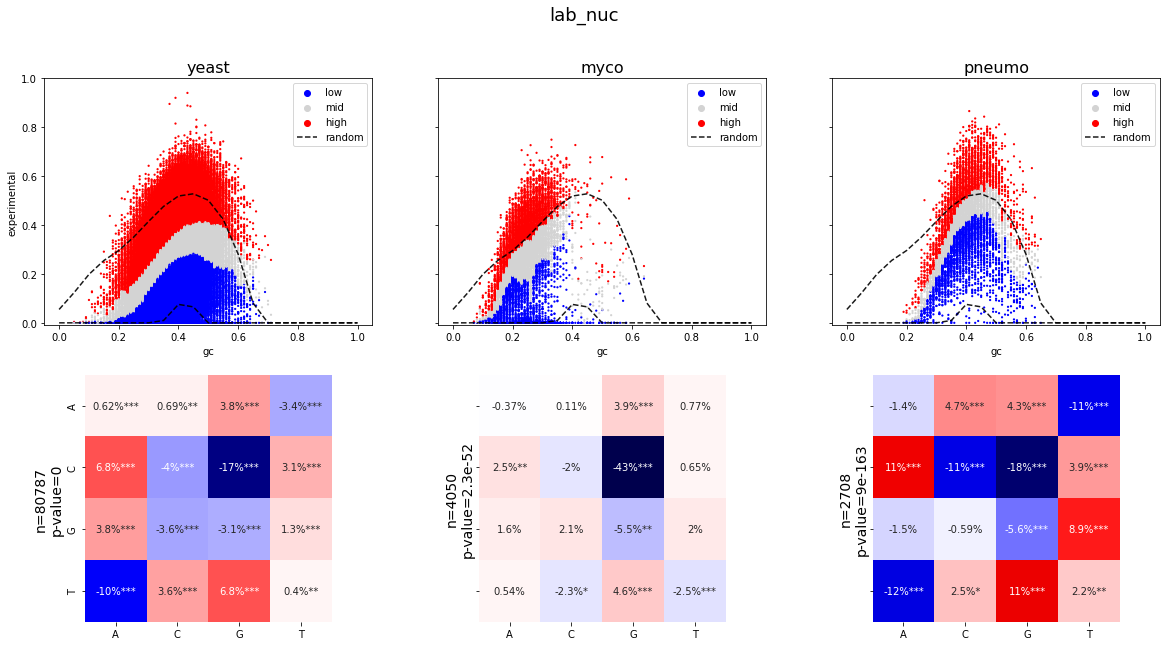

In [134]:
annot = 'lab_nuc'
k = 2
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, -1)
fig, axes = plt.subplots(2, 3, sharey='row', figsize=(20, 10), facecolor='w')
if annot == 'lab_nuc':
    rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
elif annot == 'lab_coh':
    rand_preds = preds_coh_rand.reshape(n_gcs, -1)
elif annot == 'lab_pol':
    rand_preds = preds_pol_rand.reshape(n_gcs, -1)
else:
    raise ValueError(f"annot can't be {annot}")
qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
titles = ['yeast', 'myco', 'pneumo']
for j, title in enumerate(titles):
    axes[0, j].set_title(title, fontsize=16)
for j, (window_df, window_one_hot) in enumerate([(window_yeast, window_one_hot_yeast),
                                                 (window_myco, window_one_hot_myco),
                                                 (window_pneu, window_one_hot_pneu)]):
    sns.scatterplot(ax=axes[0, j], data=window_df.loc[window_df[f'sep_{annot}'] != 'discarded'], x='gc', y=annot,
                    hue=f'sep_{annot}', hue_order=['low', 'mid', 'high'], palette=['b', 'lightgray', 'r'],
                    ec=None, s=5)
    axes[0, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
    axes[0, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
    axes[0, j].legend().set_title('')

    low_mask = window_df.loc[:, f'sep_{annot}'] == 'low'
    high_mask = window_df.loc[:, f'sep_{annot}'] == 'high'
    df_low = utils.kmer_counts(window_one_hot[low_mask], k, includeN=False)
    df_high = utils.kmer_counts(window_one_hot[high_mask], k, includeN=False)
    df_pvals = pd.Series(
        0.,
        index=df_low.index)
    for kmer in df_low.index:
        df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
            [[df_high.loc[kmer], df_high.loc[df_high.index!=kmer].sum()],
             [df_low.loc[kmer], df_low.loc[df_low.index!=kmer].sum()]]
        )[1]
    global_pval = scipy.stats.chi2_contingency(pd.concat([df_high, df_low], axis=1))[1]
    df_pvals2D = df_pvals.sort_index()
    
    df_percdiff = (df_high - df_low) / (df_high + df_low) * 200
    df_percdiff2D = df_percdiff.sort_index()

    stars = np.argmax(df_pvals2D.to_numpy().reshape(16, 1) > stars_thres, axis=1)
    annotation = np.array([f"{format(v, '.2g')}%" + "*"*s for v, s in zip(df_percdiff2D.values, stars)]).reshape(4, 4)
    sns.heatmap(df_percdiff2D.unstack(), cmap='seismic', annot=annotation, fmt='', ax=axes[1, j], center=0, vmax=20, cbar=False, square=True)
    lab = (f'n={low_mask.sum()}\n'
           f'p-value={format(global_pval, ".2g")}')
    axes[1, j].set_ylabel(lab, fontsize=14)

axes[0, 1].set_ylim(bottom=-0.01, top=1)
axes[0, 0].set_ylabel('experimental')
fig.suptitle(annot, fontsize=18)

Text(153.0, 0.5, 'experimental')

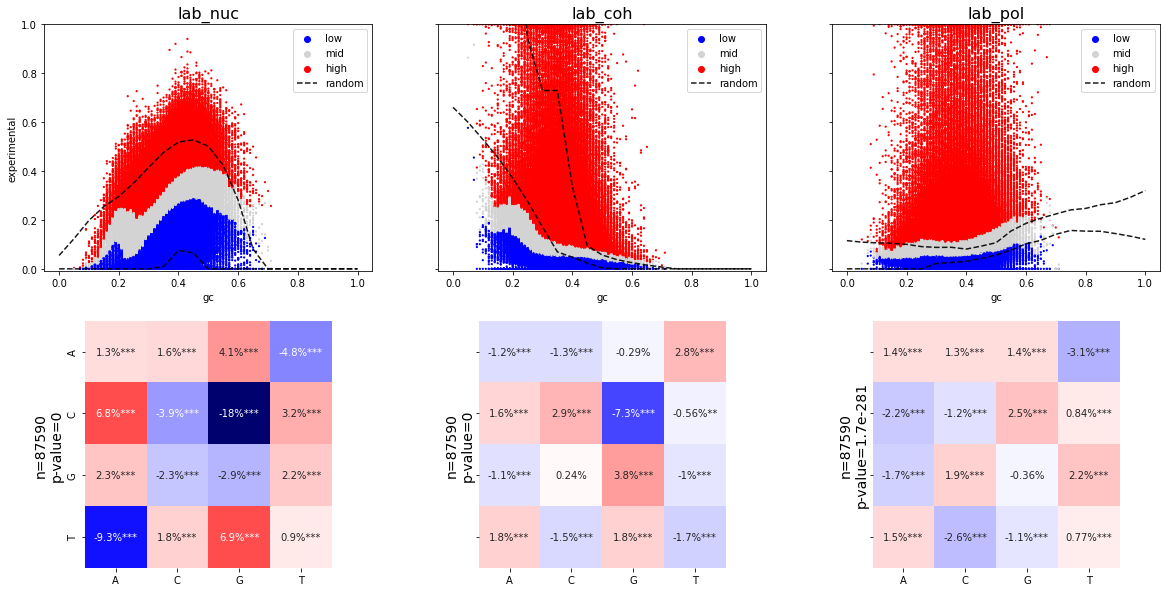

In [135]:
k = 2
stars_thres = np.array([0.05, 1e-2, 1e-3, -1]).reshape(1, -1)
fig, axes = plt.subplots(2, 3, sharey='row', figsize=(20, 10), facecolor='w')
titles = ['lab_nuc', 'lab_coh', 'lab_pol']
for j, annot in enumerate(titles):
    if annot == 'lab_nuc':
        rand_preds = preds_nuc_rand.reshape(n_gcs, -1)
    elif annot == 'lab_coh':
        rand_preds = preds_coh_rand.reshape(n_gcs, -1)
    elif annot == 'lab_pol':
        rand_preds = preds_pol_rand.reshape(n_gcs, -1)
    else:
        raise ValueError(f"annot can't be {annot}")
    qmin, qmax = np.quantile(rand_preds, [0.05, 0.95], axis=1)
    axes[0, j].set_title(annot, fontsize=16)
    sns.scatterplot(ax=axes[0, j], data=window_full.loc[window_full[f'sep_{annot}'] != 'discarded'], x='gc', y=annot,
                    hue=f'sep_{annot}', hue_order=['low', 'mid', 'high'], palette=['b', 'lightgray', 'r'],
                    ec=None, s=5)
    axes[0, j].plot(gcs, qmin, color='k', linestyle='--', alpha=0.9, label='random')
    axes[0, j].plot(gcs, qmax, color='k', linestyle='--', alpha=0.9)
    axes[0, j].legend().set_title('')

    low_mask = window_full.loc[:, f'sep_{annot}'] == 'low'
    high_mask = window_full.loc[:, f'sep_{annot}'] == 'high'
    df_low = utils.kmer_counts(window_one_hot_full[low_mask], k, includeN=False)
    df_high = utils.kmer_counts(window_one_hot_full[high_mask], k, includeN=False)
    df_pvals = pd.Series(
        0.,
        index=df_low.index)
    for kmer in df_low.index:
        df_pvals.loc[kmer] = scipy.stats.chi2_contingency(
            [[df_high.loc[kmer], df_high.loc[df_high.index!=kmer].sum()],
             [df_low.loc[kmer], df_low.loc[df_low.index!=kmer].sum()]]
        )[1]
    global_pval = scipy.stats.chi2_contingency(pd.concat([df_high, df_low], axis=1))[1]
    df_pvals2D = df_pvals.sort_index()
    
    df_percdiff = (df_high - df_low) / (df_high + df_low) * 200
    df_percdiff2D = df_percdiff.sort_index()

    stars = np.argmax(df_pvals2D.to_numpy().reshape(16, 1) > stars_thres, axis=1)
    annotation = np.array([f"{format(v, '.2g')}%" + "*"*s for v, s in zip(df_percdiff2D.values, stars)]).reshape(4, 4)
    sns.heatmap(df_percdiff2D.unstack(), cmap='seismic', annot=annotation, fmt='', ax=axes[1, j], center=0, vmax=20, cbar=False, square=True)
    lab = (f'n={low_mask.sum()}\n'
           f'p-value={format(global_pval, ".2g")}')
    axes[1, j].set_ylabel(lab, fontsize=14)

axes[0, 1].set_ylim(bottom=-0.01, top=1)
axes[0, 0].set_ylabel('experimental')